## JR DATA SCIENTIST 
### Lena Valeska Peroni
### Mail: lena.peroni@gmail.com

El objetivo de este trabajo es analizar un dataset de interacciones de usuarios con la pagina de Google Store. Se realizara un analisis exploratorio de los datos y luego se intentara estimar la probabilidad de que un usuario convierta.

In [274]:
#Importo las librerias a usar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates 
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.ensemble import RandomForestClassifier # Random forests para decisión

# Módulos utiles para evaluar el modelo 
from sklearn.model_selection import train_test_split # Para separar en train y test
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import brier_score_loss



### Exploramos y limpiamos los datos

Cargamos los datos y luego de un analisis exploratorio vemos que hay varias columnas con NANs, las completamos con 0. En este caso tiene sentido por el tipo de datos que manejamos (si estuvieramos trabajando con edades por ejemplo deberiamos completarlo de otra manera.) Cambiamos el tipo de algunos datos para que coincida con el dtype de la consigna. Cambiamos la fecha a datetime para poder usar metodos de tiempo.

In [275]:
fileName = 'data.csv'
data = pd.read_csv(fileName, sep = ",")

/tmp/ipykernel_135498/2619749747.py:2: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



Se sabe que el total de las ventas suele venir de un pequeño numero de clientes. Es interesante entonces poder predecir si un cliente o no comprara. Luego se puede analizar los atributos de los clientes que compran y tomar decisiones de marketing orientadas. Por ejemplo se puede segmentar el publico y hacer campañas orientadas a los posibles compradores y otras a los clientes que no suelen comprar.

In [276]:
print('Total de registros: ', len(data), 'registros que no convierten: ',data['transactionRevenue'].isna().sum())
gdf = data.groupby("fullVisitorID")["transactionRevenue"].sum().reset_index()
nzr = (gdf["transactionRevenue"]>0).sum()
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Total de registros:  392892 registros que no convierten:  387615
Number of unique customers with non-zero revenue :  4841 and the ratio is :  0.014905153223497246


Ya en esta instancia podemos ver que de todas las instancias de ingreso de a la pagina solo un pequeñisimo numero termina en compra. 

In [277]:
#Me fijo que columnas tienen missing values y los completo con 0
data.fillna({'bounces' : 0,'timeOnSite':0, 'transactionRevenue':0,'transactions':0, "pageViews":0}, inplace=True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fullVisitorID       392892 non-null  object 
 1   visitNumber         392892 non-null  int64  
 2   date                392892 non-null  int64  
 3   bounces             392892 non-null  float64
 4   hits                392892 non-null  int64  
 5   pageviews           392856 non-null  float64
 6   timeOnSite          392892 non-null  float64
 7   transactionRevenue  392892 non-null  float64
 8   transactions        392892 non-null  float64
 9   source              392892 non-null  object 
 10  channelGrouping     392892 non-null  object 
 11  browser             392892 non-null  object 
 12  deviceCategory      392892 non-null  object 
 13  country             392892 non-null  object 
 14  city                392892 non-null  object 
dtypes: float64(5), int64(3), object(7)

El objetivo de este ejercicio es estimar si un usuario va a comprar o no. A manera de simplificar los datos para el modelo trabajamos con una variable conversionBool que es un booleano que indica si un dado usuario convirtio o no. De esta manera los usuarios pueden clasificarse en dos tipos (compra/no compra).

In [278]:
#Me interesa si un dado visitor convirtio (es decir, realizo una transaccion) o no. Creo una columna de booleanos (1 o 0) que me indique si convirtio (1) o no (0)
data['conversionBool'] = np.where(data['transactions'] > 0, 1, 0)

In [279]:
#Preprocesamiento de los datos para que esten en el formato requerido.

data['date'] = data['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')) 
data['transactionRevenue'] = data['transactionRevenue'].astype('float')
data['transactions'] = data['transactions'].astype('float')
data['fullVisitorID'] = data['fullVisitorID'].astype('string') #Por si el ID empezara en 0 para que no se confunda con otro (por ejemplo 01 y 1 son usuarios diferentes)

Para entender el comportamiento de los usuarios me interesa dividirlos en categorias. En este caso divido a los clientes en cohortes segun la primera fecha de ingreso a la pagina.
Me interesa seguir el comportameinto de esos clientes a lo largo del tiempo.  

In [280]:
data['Month'] = data['date'].dt.to_period('M') #Obtengo el mes correspondiente al registro
data['cohort'] = data.groupby('fullVisitorID')['date'].transform('min').dt.to_period('M') #De todas las fechas en la que entra un cliente me quedo con la primera
data['login_date'] = data.groupby('fullVisitorID')['date'].transform('min')
#data['timeSinceLogin'] = data['date'] - data['login_date'] 

In [281]:
df_cohort = data.groupby(['cohort', 'Month']).agg(n_customers=('fullVisitorID', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.Month - df_cohort.cohort).apply(attrgetter('n'))

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [282]:
sorted_data = data.sort_values("date")
sorted_data = sorted_data[sorted_data['transactions'] != 0]
purchase = sorted_data.groupby('fullVisitorID').agg({'date':min, 'login_date':min})
purchase.reset_index(level=['fullVisitorID'], inplace=True)
purchase['loginToPurchase'] = (purchase['date'] - purchase['login_date']).dt.days

data['loginToPurchase'] = data['fullVisitorID'].map(purchase.set_index('fullVisitorID')['loginToPurchase'])


Me interesa predecir si un cliente en particular va a comprar o no entonces agrupo los datos por cliente. Para las variables numericas considero la suma de todas sus interacciones en la pagina como indicadora de su comportamiento. Del analisis de cohortes se puede ver que la retencion de usuarios es minima, entonces se estima que el proceso de compra se dara en una ventana temporal corta, de aproximadamente una semana. De esta manera no me parece erroneo sumar todas las interacciones del usuario y considerarlas parte del mismo proceso de compra ya que no estan tan alejadas en el tiempo. 

In [283]:
#Agrego los datos para cada cliente particular
#Cuando el analisis se hace con la moda, habiendo mas de una moda posible se elige el primer valor que es devuelto
client_data = data.groupby('fullVisitorID').agg({'visitNumber': 'sum', 
                                        'bounces': 'sum',
                                        'hits': 'sum', 
                                        'pageviews':'sum',
                                        'timeOnSite': 'sum',
                                        'transactionRevenue': 'sum',
                                        'transactions': 'sum', 
                                        'source':lambda x: x.mode().iloc[0], 
                                        'country':lambda x: x.mode().iloc[0],
                                        'channelGrouping':lambda x: x.mode().iloc[0], 
                                        'conversionBool':'max',
                                        'cohort':'min',
                                        'loginToPurchase':min})

In [284]:
dictClientData = {'visitNumber': 'totalVisits',	'bounces':'totalBounced'}
client_data.rename(columns = dictClientData, inplace = True)
client_data.reset_index(level=['fullVisitorID'], inplace=True)

#client_data.describe().transpose()


### Visualizacion

Hacemos un analisis de correlacion entre variables para ver cuales pueden ser buenos predictores de la compra y cuales son redundantes. Vemos que hits, pageviews y time on site son buenos candidatos para predecir a conversionBool.

<AxesSubplot:>

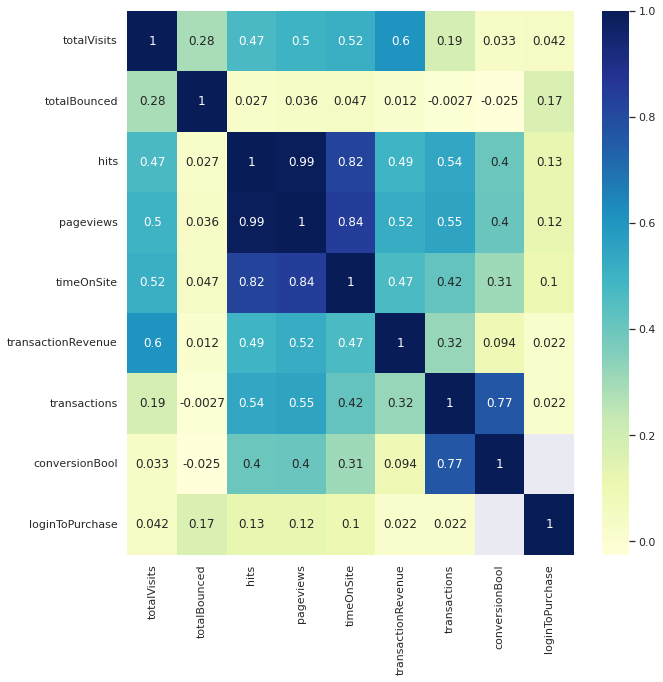

In [285]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(client_data.corr(), cmap="YlGnBu", annot=True)

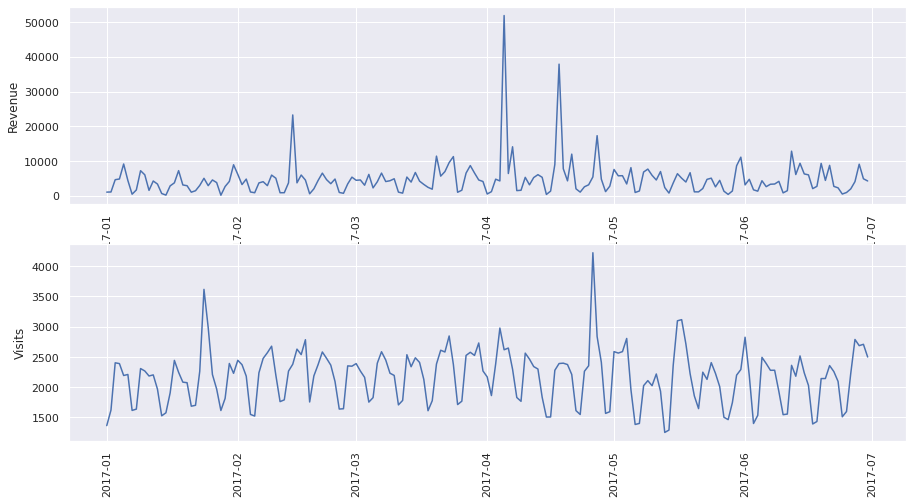

In [286]:
plot_df = data.groupby(by=['date']).agg({'fullVisitorID':'count','transactionRevenue':'sum'}).reset_index()

fig = plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(pd.to_datetime(plot_df['date']),plot_df['transactionRevenue'])
plt.ylabel('Revenue')
plt.xticks(rotation=90)

plt.subplot(2,1,2)
plt.plot(pd.to_datetime(plot_df['date']),plot_df['fullVisitorID'])
plt.ylabel('Visits')
plt.xticks(rotation=90);

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)


Analizamos la ganancia total por dia y asimismo analizo el total de visitas ese dia. Vemos que en febrero y en abril hay dos picos de ganancia. Se podria analizar si estos picos se corresponden con campañas de publicidad o descuentos y de esta manera se verifica que fueron exitosos. Tambien podria explicarse el pico de ganancias en febrero relacionado con una fecha especial de alto consumo (san valentin). 

Se ve en el numero de visitas que hay un pequeño lag correspondiente a un pico de visitas a fines de enero y un pico de compras en febrero. Esto tiene sentido con el analisis previo que se hizo en el que se considera los periodos de compra como durando aproximadamente 7-10 dias.


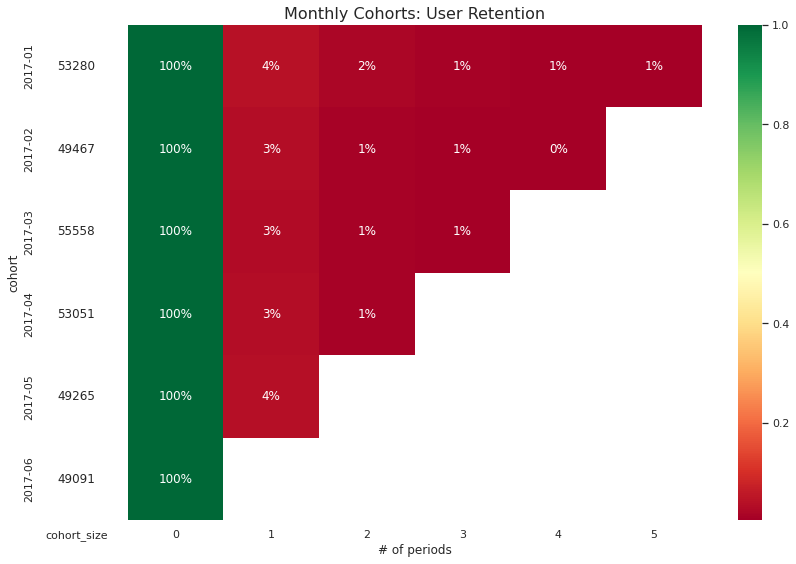

In [287]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

En el analisis de la retencion resulta evidente que la retencion de los usuarios es baja. Despues del primer mes la retencion cae drasticamente, con solo el 3% de los clientes aproximadamente volviendo a entrar a la pagina. Para todos los cohortes esta tendencia a baja retencion se mantiene. 

In [288]:
channels = list(data['channelGrouping'].unique())
datos = []
for channel in channels:
    subset = data[data['channelGrouping']==channel]
    subset = subset.groupby('date')['transactionRevenue'].agg(['sum'])
    subset.columns = ["Total"]
    subset = subset.sort_index()
    trace = go.Scatter(
        x = subset['Total'].index,
        y = subset['Total'].values,
        name=channel,
        mode='lines'
    )
    datos.append(trace)
layout= go.Layout(
    title= 'Transacciones totales por dia por canal',
    xaxis = dict(title = 'Date'), yaxis = dict(title = 'Total'),
    showlegend=True,
)
fig = dict(data=datos, layout=layout)
iplot(fig, filename='lines')

Se analiza a que canal se pueden atribuir las ventas de un dado periodo. Se ve que los usuarios que entraron en el pico de compras del mes de febrero lo hicieron de manera directa mientras que en abril vienen de display advertising. Esto nos indica que si hubo una campaña en ese mes, esta fue exitosa. 

In [289]:
def plotmap(frame, z_var, countries_col, title, colorscale, rcolor=True):

    dato = [ dict(
            type = 'choropleth',
            autocolorscale = False,
            colorscale = colorscale,
            showscale = True,
            reversescale = rcolor,
            locations = frame[countries_col],
            z = frame[z_var],
            locationmode = 'country names',
            text = frame[countries_col],
            marker = dict(line = dict(color = '#fff', width = 2))
        )           
    ]

    layout = dict(
        height=680,
        width=1200,
        title = title,
        geo = dict(
            showframe = False,
            showcoastlines = False,
            projection = dict(type = 'mercator'),
        ),
    )
    fig = dict(data=dato, layout=layout)
    iplot(fig)

colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]
    
# Plot world map - total visits
tmp = data["country"].value_counts().to_frame().reset_index()
plotmap(tmp, 'country', 'index', 'Total visits by Country', colorscale, False)

colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
        [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]]



## Modelo

### Seleccion del modelo

Siendo que nuestro dataset contiene valores faltantes, outliers, variables numericas y variables categoricas decido usar Random Forest. Otra ventaja del metodo es que no se ve muy afectado si hubiera clases desbalanceadas.
Al final lo que se busca obtener es la probabilidad de a que clase (compradores o no) pertenece cada instancia (cada visitor).

 Se considero tambien utilizar un Multilayer Perceptron y Boosted Trees pero el tiempo de ejecucion fue tan elevado que los descarte. 

Se trabajara con los datos agrupados por cliente como se menciono arriba.

0. Tranformamos los datos
1. Separamos los datos en train\test\validation
2. Fiteamos y evaluamos un modelo
3. Tuneamos los hiperparametros
4. Evaluamos en el set de validacion
5. Evaluamos el modelo final en el test set

#### 0. Transformamos los datos 
Las variables categoricas son transformadas a variables dummy para ser utilizadas por el modelo. Como hay muchos paises poco frecuentes en el dataset los agrupo como OTROS.

In [290]:
# # Elimino países con menos visitas que el 1% de los datos totales
client_data['country'] = client_data['country'].astype('category')

others = client_data['country'].value_counts().index[5:]
label = 'Other'

client_data['country'] = client_data['country'].cat.add_categories([label])
client_data['country'] = client_data['country'].replace(others, label)


In [291]:
# # Elimino países con menos visitas que el 1% de los datos totales
client_data['source'] = client_data['source'].astype('category')

others = client_data['source'].value_counts().index[5:]
label = 'Other'

client_data['source'] = client_data['source'].cat.add_categories([label])
client_data['source'] = client_data['source'].replace(others, label)

In [292]:
dataClean = pd.get_dummies(client_data,drop_first=True,columns=["source","channelGrouping",'country'])

#### 1. Separamos los datos en train\test\validation

La variable a predecir sera conversionBool que nos dice si el cliente compro o no. Sacamos columnas que sean redundantes como transactionRevenue y transactions.

In [293]:
features = dataClean.drop(['conversionBool', 'transactionRevenue',	'transactions', 'loginToPurchase', 'cohort'], axis=1).astype(float)
labels = dataClean['conversionBool'].astype(float)

#Quiero dejar datos para validar. Al principio seleccionamos el 40% de la data para el test
# y nos quedamos con 60 para el training. Sobre el 40 volvemos a correr tts para tener 20 para validar
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [294]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset)/len(labels),2))

0.6
0.2
0.2


####
2. Fiteamos y evaluamos un modelo
3. Tuneamos los hiperparametros

In [295]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [296]:
#Genero el modelo 
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50],
    'max_depth': [2, 4, 8, 16, 32, None]
}

In [297]:
#Hacemos cross validation para la combinacion de hiperparametros que me de mejor performance
cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 16, 'n_estimators': 50}

0.985 (+/-0.0) for {'max_depth': 2, 'n_estimators': 5}
0.985 (+/-0.0) for {'max_depth': 2, 'n_estimators': 50}
0.986 (+/-0.001) for {'max_depth': 4, 'n_estimators': 5}
0.985 (+/-0.0) for {'max_depth': 4, 'n_estimators': 50}
0.987 (+/-0.001) for {'max_depth': 8, 'n_estimators': 5}
0.987 (+/-0.001) for {'max_depth': 8, 'n_estimators': 50}
0.986 (+/-0.001) for {'max_depth': 16, 'n_estimators': 5}
0.987 (+/-0.0) for {'max_depth': 16, 'n_estimators': 50}
0.985 (+/-0.001) for {'max_depth': 32, 'n_estimators': 5}
0.986 (+/-0.001) for {'max_depth': 32, 'n_estimators': 50}
0.985 (+/-0.001) for {'max_depth': None, 'n_estimators': 5}
0.986 (+/-0.0) for {'max_depth': None, 'n_estimators': 50}


Pruebo diferentes hiperparametros y selecciono los que den mejor performance, en este caso lo que se busca es minimizar la varianza. Una vez elegidos los hiperparametros se fitea el modelo que luego se evaluara segun ciertas metricas.  

In [303]:
rf = RandomForestClassifier(max_depth=16, n_estimators=50)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=50)

In [304]:
#Evaluamos el modelo 
def evaluate_model(name, model, features, labels):
    pred = model.predict(features)
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} '.format(name,
                                                                    accuracy,
                                                                    precision,
                                                                    recall,
                                                                    ))

####
4. Evaluamos en el set de validacion
En esta instancia si estuviera probando diferentes algoritmos puedo en la etapa de validacion elegir el mejor modelo

In [305]:
evaluate_model('Random Forest',rf,X_val, y_val)

Random Forest -- Accuracy: 0.987 / Precision: 0.651 / Recall: 0.318 


#####
5. Evaluo el modelo en los datos de testeo

In [306]:
evaluate_model('Random Forest',rf,X_test, y_test)

Random Forest -- Accuracy: 0.986 / Precision: 0.604 / Recall: 0.289 


## Performance Metrics

Las metricas que uso para evaluar son: 

### Accuracy = # predicted correctly/total # examples
### Precision = #predicted as buyers that actually bought /total predicted to buy

La precision me da una idea de cuanto compraron realmente si el modelo dijo que iba a comprar. 

### Recall = #predicted as buyers that actually bought /total number that actually bought
El recall indica cual es la probabilidad de que el modelo prediga que alguien compro cuando de hecho compraron.


In [307]:
#Me fijo en esta instancia la performance del modelo con Brier Score. Lo uso ya que funciona para variables binarias. Buscamos minimizar el valor de loss
preds = rf.predict_proba(X_test)[:,1]
brier_score_loss(y_test,preds)

0.009646091224430118